# Loan Status Prediction Analysis

* This project target to predict the loan status given its properties

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns

In [130]:
df = pd.read_csv('train_u6lujuX_CVtuZ9i.csv',index_col="Loan_ID")

### Part 1. EDA
* univariate analysis 
* missing value imputation
* scaling and transforming
* correlation 

*continuous var analysis VS descrete var analysis*

In [131]:
df.describe().columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [132]:
identifier=[x not in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Loan_Amount_Term', 'Credit_History'] for x in df.columns]

In [133]:
toanalyze=[]
for i in zip(df.columns.get_values().tolist(),identifier):
    if i[1] ==True:
        toanalyze.append(i[0])

In [134]:
toanalyze

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [135]:
df[['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 7 columns):
Gender           601 non-null object
Married          611 non-null object
Dependents       599 non-null object
Education        614 non-null object
Self_Employed    582 non-null object
Property_Area    614 non-null object
Loan_Status      614 non-null object
dtypes: object(7)
memory usage: 38.4+ KB


In [136]:
pd.crosstab(df['Gender'], df['Married'])

Married,No,Yes
Gender,,
Female,80,31
Male,130,357


In [137]:
df['Gender'].fillna('Male',inplace=True)

In [138]:
df['Married'].fillna(df[df['Married'].isnull()].apply(lambda x: {'Female':'No','Male':'Yes'}[x['Gender']] ,axis=1),inplace=True)

In [139]:
DepFill=round(df.groupby(['Gender','Married']).count()['Dependents'].unstack().apply(lambda x:x/sum(x),axis=1),0).astype(int).astype(str)
# imputation
df['Dependents'].fillna(df[df['Dependents'].isnull()].
                        apply(lambda x: DepFill.loc[x['Gender'],x['Married']] ,axis=1),inplace=True)

In [140]:
df["Self_Employed"].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [141]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print ('Frequency Table for Credit History:' )
print (temp1)

print ('\nProbility of getting loan for each Credit History class:' )
print (temp2)

Frequency Table for Credit History:
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probility of getting loan for each Credit History class:
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


*with credit history loan is more likely to get approved*

In [142]:
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)

In [143]:
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean(), inplace=True)
df['Self_Employed'].fillna('No', inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mean(), inplace=True)

In [144]:
# double check the missing value filling result
df.apply(lambda x: sum(x.isnull()),axis=0)## .value_counts()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

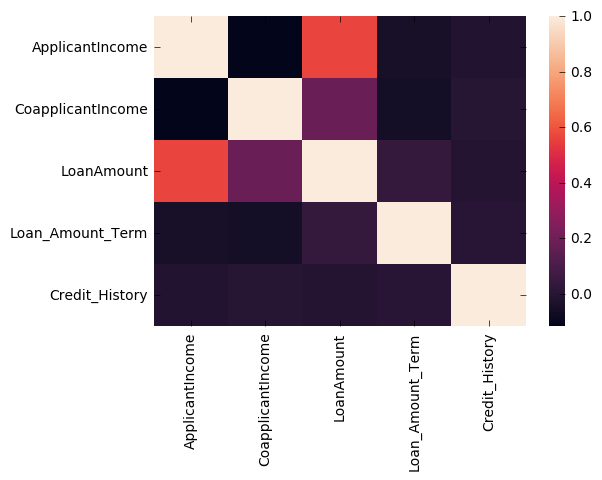

In [145]:
# Using heatmap to understand correlation between variables
sns.heatmap(df.corr())

### Part 2. Feature Engineering
* scaling variables & create new variables 

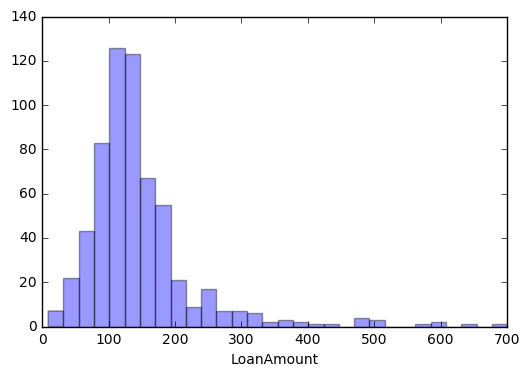

In [146]:
sns.distplot(df['LoanAmount'],kde=False,bins=30)

*loan amount follows log normal distribution, would apply log transform*

In [147]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])

C:\Users\Yilun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


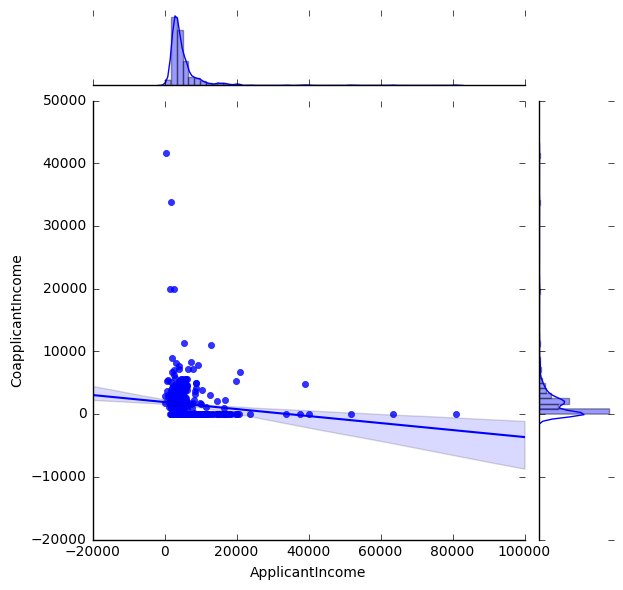

In [148]:
sns.jointplot(x='ApplicantIncome',y='CoapplicantIncome',data=df,kind='reg')

*Applicant income and coapplicant income all follows log normal distribution. The sum of these 2 might reflect the overall credibility of the application, so I combined them together*

In [149]:
df['Income']=df[['ApplicantIncome','CoapplicantIncome']].apply(lambda x:sum(x),axis=1)##[:,0]

df['LogIncome']=np.log(df['Income'])

In [150]:
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']

In [151]:
from sklearn.preprocessing import LabelEncoder
for i in var_mod:
    df[i]=LabelEncoder().fit_transform(df.loc[:,i])

In [152]:
df.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'LoanAmount_log', 'Income', 'LogIncome'],
      dtype='object')

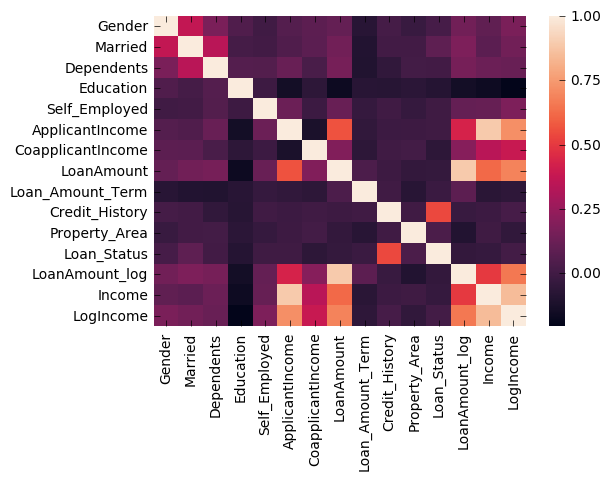

In [153]:
sns.heatmap(df.corr())

### Part 3. Model Building
* undersand model evaluation metrics
* tune and cross validation

In [154]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

In [155]:
from sklearn.ensemble import GradientBoostingClassifier as xgboost

In [156]:
from sklearn import svm

In [157]:
from sklearn import neighbors, datasets, preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [158]:
from sklearn.metrics import r2_score

In [159]:
lm=LogisticRegression()

X,y=df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 
       'LoanAmount_log', 'LogIncome']],df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33,  random_state=33)

print('number of train example {}'.format(y_train.count()))

lm.fit(X_train,y_train)

pred=lm.predict(X_test)

output=pd.DataFrame()
output['Pred']=pred.tolist()
output['Act']=y_test.tolist()

r2_score(output['Act'],output['Pred'])

pd.crosstab(output['Pred'],output['Act']).apply(lambda x:x/sum(x),axis=0)

pd.crosstab(output['Pred'],output['Act']).apply(lambda x:x/sum(x),axis=1)

accuracy_score(output['Act'],output['Pred'])

from sklearn.metrics import classification_report
print(classification_report(output['Act'],output['Pred']))

number of train example 411
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        60
          1       0.70      1.00      0.83       143

avg / total       0.50      0.70      0.58       203



C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


*the model can hardly predict rejected loan, the predictive power is low*

In [160]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lm.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

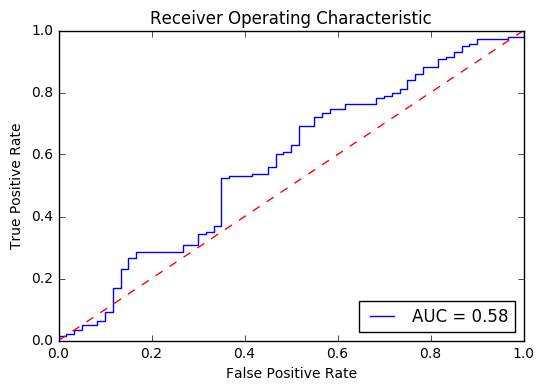

In [161]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [163]:
lm=LogisticRegression()

X,y=df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 
       'LoanAmount_log', 'LogIncome','Credit_History']],df['Loan_Status']

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33,  random_state=33)

y_train.count()

lm.fit(X_train,y_train)

pred=lm.predict(X_test)

output=pd.DataFrame()
output['Pred']=pred.tolist()
output['Act']=y_test.tolist()

In [165]:
r2_score(output['Act'],output['Pred'])

pd.crosstab(output['Pred'],output['Act']).apply(lambda x:x/sum(x),axis=0)

pd.crosstab(output['Pred'],output['Act']).apply(lambda x:x/sum(x),axis=1)

accuracy_score(output['Act'],output['Pred'])

0.812807881773399

In [166]:
from sklearn.metrics import classification_report
print(classification_report(output['Act'],output['Pred']))

             precision    recall  f1-score   support

          0       0.89      0.42      0.57        60
          1       0.80      0.98      0.88       143

avg / total       0.83      0.81      0.79       203



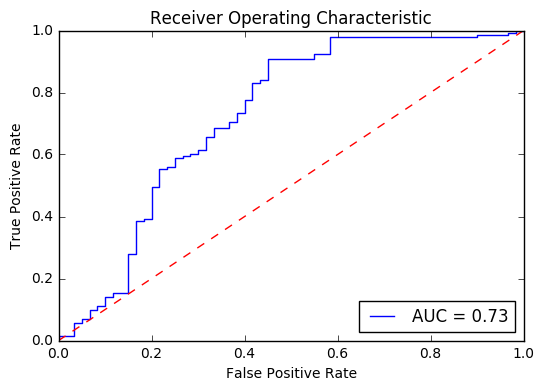

In [167]:
probs = lm.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*Credit History contribute a lot to the accuracy*

In [50]:
svc = svm.SVC(kernel='linear')

X,y=df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 
       'LoanAmount_log', 'LogIncome','Credit_History']],df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33,  random_state=33)

y_train.count()

svc.fit(X_train,y_train)

pred=svc.predict(X_test)

output=pd.DataFrame()
output['Pred']=pred.tolist()
output['Act']=y_test.tolist()

r2_score(output['Act'],output['Pred'])

pd.crosstab(output['Pred'],output['Act']).apply(lambda x:x/sum(x),axis=0)

pd.crosstab(output['Pred'],output['Act']).apply(lambda x:x/sum(x),axis=1)

accuracy_score(output['Act'],output['Pred'])

from sklearn.metrics import classification_report
print(classification_report(output['Act'],output['Pred']))

             precision    recall  f1-score   support

          0       0.89      0.42      0.57        60
          1       0.80      0.98      0.88       143

avg / total       0.83      0.81      0.79       203



*both method yields similar result*

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
standardized_X = scaler.transform(X_train)
standardized_X_test = scaler.transform(X_test)

In [53]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

In [54]:
svc.fit(standardized_X,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
pred=svc.predict(standardized_X_test)

In [56]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.89      0.42      0.57        60
          1       0.80      0.98      0.88       143

avg / total       0.83      0.81      0.79       203



*scaling could make the result better but not significant in this case*

### Generic function for making a classification model and accessing performance

In [58]:

def classification_model(model, data, predictors, outcome):
    ##Fit the model:
    model.fit(data[predictors],data[outcome])
      
      #Make predictions on training set:
    predictions = model.predict(data[predictors])
      
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print ('Accuracy : %s' % "{0:.3%}".format(accuracy))
    
    #Perform k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:
        # Filter training data
        train_predictors = (data[predictors].iloc[train,:])
        
        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]
        
        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)
        
        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
     
    print( "Cross-Validation Score : %s" % "{0:.8%}".format(np.mean(error)))
    
      #Fit the model again so that it can be refered outside the function:
    model.fit(data[predictors],data[outcome]) 

In [62]:
df_clean=df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 
       'LoanAmount_log', 'LogIncome','Credit_History','Loan_Status']]

In [63]:
outcome_var = 'Loan_Status'
model = svm.SVC()
predictor_var = ['Credit_History']
classification_model(model, df_clean,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.94628815%


In [65]:
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History','LogIncome']
classification_model(model, df_clean,predictor_var,outcome_var)


Accuracy : 80.945%
Cross-Validation Score : 80.94628815%


In [66]:
outcome_var = 'Loan_Status'
model = RandomForestClassifier()
predictor_var = ['Credit_History','LogIncome']
classification_model(model, df_clean,predictor_var,outcome_var)

Accuracy : 95.440%
Cross-Validation Score : 73.61588698%


In [69]:
outcome_var = 'Loan_Status'
model = xgboost()
predictor_var = ['Credit_History','LogIncome']
classification_model(model, df_clean,predictor_var,outcome_var)

Accuracy : 87.459%
Cross-Validation Score : 78.34199653%


In [70]:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df_clean,predictor_var,outcome_var)

Accuracy : 81.107%
Cross-Validation Score : 79.64147674%


Generally we expect the accuracy to increase on adding variables. But this is a more challenging case. The accuracy and cross-validation score are not getting impacted by less important variables. Credit_History is dominating the mode. We have two options now:

Feature Engineering: dereive new information and try to predict those. I will leave this to your creativity.
Better modeling techniques. Let’s explore this next.

In [268]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Gender','Married','Education']
classification_model(model, df_clean,predictor_var,outcome_var)

Accuracy : 81.560%
Cross-Validation Score : 81.56028369%


In [269]:
#We can try different combination of variables:
predictor_var = ['Credit_History','totalincomelog']
classification_model(model, df_clean,predictor_var,outcome_var)

Accuracy : 98.050%
Cross-Validation Score : 71.09929078%


In [272]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','totalincomelog']
classification_model(model, df_clean,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 78.36879433%


In [275]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Credit_History','totalincomelog','LoanAmount_log']
classification_model(model, df_clean,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 74.11347518%


In [273]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print (featimp)

Credit_History      0.289187
totalincomelog      0.255176
LoanAmount_log      0.214610
Dependents          0.050819
Loan_Amount_Term    0.050553
Property_Area       0.047697
Married             0.025751
Education           0.022591
Gender              0.022305
Self_Employed       0.021311
dtype: float64


In [278]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['totalincomelog','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model, df_clean,predictor_var,outcome_var)

Accuracy : 83.333%
Cross-Validation Score : 81.02836879%


### Using a more sophisticated model does not guarantee better results.
* Avoid using complex modeling techniques as a black box without understanding the underlying concepts
* Using complex modeland adding irrelavent features would increase the tendency of overfitting thus making your models less interpretable
* Feature Engineering is the key to success. Here we found key factors suits the model
* Using feature importance from random forest could help validate 

In [71]:
pd.DataFrame(model.feature_importances_ ,index=predictor_var,columns=['Imp']).sort_values(by='Imp',ascending=False)

,Imp
Credit_History,0.364507
Self_Employed,0.303326
Property_Area,0.175997
Education,0.113607
Married,0.042562
